In [1]:
# import libraries
%matplotlib inline
import numpy as np
#import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.spatial

In [2]:
ghcn = pd.read_fwf('data/ghcnd-stations.txt', colspecs = [(0,11), (12,19), (21,29), (31,36),(38,40), (41,70), (72,74),(76,78),(80,85)], header = None) 
colnames = ['GHCN ID', 'lat', 'lon', 'elevation', 'state', 'name', 'gsn flag', 'HCN/CRN FLAG', 'WMO ID']
ghcn.columns = colnames

# append the brightness index 
BI = np.load('data/brightnessGHCN.npy')
ghcn['Brightness'] = BI
# from http://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt
# FORMAT OF "ghcnd-stations.txt"
#
# ------------------------------
# Variable   Columns   Type
# ------------------------------
# ID            1-11   Character
# LATITUDE     13-20   Real
# LONGITUDE    22-30   Real
# ELEVATION    32-37   Real
# STATE        39-40   Character
# NAME         42-71   Character
# GSN FLAG     73-75   Character
# HCN/CRN FLAG 77-79   Character
# WMO ID       81-85   Character
# ------------------------------

# These variables have the following definitions:

# ID         is the station identification code.  Note that the first two
#            characters denote the FIPS  country code, the third character 
#            is a network code that identifies the station numbering system 
#            used, and the remaining eight characters contain the actual 
#            station ID. 

#            See "ghcnd-countries.txt" for a complete list of country codes.
# 	   See "ghcnd-states.txt" for a list of state/province/territory codes.

#            The network code  has the following five values:

#            0 = unspecified (station identified by up to eight 
# 	       alphanumeric characters)
# 	   1 = Community Collaborative Rain, Hail,and Snow (CoCoRaHS)
# 	       based identification number.  To ensure consistency with
# 	       with GHCN Daily, all numbers in the original CoCoRaHS IDs
# 	       have been left-filled to make them all four digits long. 
# 	       In addition, the characters "-" and "_" have been removed 
# 	       to ensure that the IDs do not exceed 11 characters when 
# 	       preceded by "US1". For example, the CoCoRaHS ID 
# 	       "AZ-MR-156" becomes "US1AZMR0156" in GHCN-Daily
#            C = U.S. Cooperative Network identification number (last six 
#                characters of the GHCN-Daily ID)
# 	   E = Identification number used in the ECA&D non-blended
# 	       dataset
# 	   M = World Meteorological Organization ID (last five
# 	       characters of the GHCN-Daily ID)
# 	   N = Identification number used in data supplied by a 
# 	       National Meteorological or Hydrological Center
# 	   R = U.S. Interagency Remote Automatic Weather Station (RAWS)
# 	       identifier
# 	   S = U.S. Natural Resources Conservation Service SNOwpack
# 	       TELemtry (SNOTEL) station identifier
#            W = WBAN identification number (last five characters of the 
#                GHCN-Daily ID)

# LATITUDE   is latitude of the station (in decimal degrees).

# LONGITUDE  is the longitude of the station (in decimal degrees).

# ELEVATION  is the elevation of the station (in meters, missing = -999.9).


# STATE      is the U.S. postal code for the state (for U.S. stations only).

# NAME       is the name of the station.

# GSN FLAG   is a flag that indicates whether the station is part of the GCOS
#            Surface Network (GSN). The flag is assigned by cross-referencing 
#            the number in the WMOID field with the official list of GSN 
#            stations. There are two possible values:

#            Blank = non-GSN station or WMO Station number not available
#            GSN   = GSN station 

# HCN/      is a flag that indicates whether the station is part of the U.S.
# CRN FLAG  Historical Climatology Network (HCN).  There are three possible 
#           values:

#            Blank = Not a member of the U.S. Historical Climatology 
# 	           or U.S. Climate Reference Networks
#            HCN   = U.S. Historical Climatology Network station
# 	   CRN   = U.S. Climate Reference Network or U.S. Regional Climate 
# 	           Network Station

# WMO ID     is the World Meteorological Organization (WMO) number for the
#            station.  If the station has no WMO number (or one has not yet 
# 	   been matched to this station), then the field is blank.

# --------------------------------------------------------------------------------
# --------------------------------------------------------------------------------
giss = pd.read_fwf('data/v3.temperature.inv.txt',skiprows = 39, header = None,
                  colspecs=[(0,3),(3,8),(8,11), (12,44),(44,49), (52,58), (58,63), (63,67), (67,68), (69,73), (73,75), (75, 77), (78,79), (79,81), (81,82),(82,84), (84,100), (100,102), (103,106)])
colnames = ['icc country code', 'WMO ID', '3 digit modifier', 'name','lat', 'lon', 'elevation', 'TELe', 'P', 'Pop', 'Tp', 'V', 'Lo', 'Co', 'Airport', 'ds', 'Vege', 'bi', 'BI']
giss.columns = colnames

# LEGEND  
# ======
# icc  =3 digit country code; the first digit represents WMO region/continent
# WMO_#=5 digit WMO station number
# ...  =3 digit modifier; 000 means the station is probably the WMO
#       station; 001, etc. mean the station is near that WMO station
# Name =30 character station name
# Lat  =latitude in degrees, negative = South of Equator
# Lon  =longitude in degrees, negative = West of Greenwich (England)
# Elev =station elevation in meters, missing is -999
# TEle =station elevation interpolated from TerrainBase gridded data set
# P    =R if rural (not associated with a town of >10,000 population)
#       S if associated with a small town (10,000-50,000 population)
#       U if associated with an urban area (>50,000 population)
# Pop  =population of the small town or urban area in 1000s
#       If rural, no analysis:  -9.
# Tp   =general topography around the station:  FL flat; HI hilly,
#       MT mountain top; MV mountainous valley or at least not on the top
#       of a mountain.
# V    =general vegetation near the station based on Operational
#       Navigation Charts;  MA marsh; FO forested; IC ice; DE desert;
#       CL clear or open;  xx information not provided
# Lo   =CO if station is within 30 km from the coast
#       LA if station is next to a large (> 25 km**2) lake
#       no if neither of the above
#       Note: Stations which are both CO and LA will be marked CO
# Co   =distance in km to the coast if Lo=CO, else -9
# A    =A if the station is at an airport; else x
# ds   =distance in km from the airport to its associated
#       small town or urban center (not relevant for rural airports
#       or non airport stations in which case ds=-9)
# Vege =gridded vegetation for the 0.5x0.5 degree grid point closest
#       to the station from a gridded vegetation data base. 16 characters.
# bi   =brightness index    A=dark B=dim C=bright   (comment added by R.Ruedy)
# BI   =brightness index    0=dark -> 256 =bright   (based on satellite night light data)

see: http://stackoverflow.com/questions/35296935/python-calculate-lots-of-distances-quickly

In [3]:
# subset the GHCN station list with the list of available stations
currentstations = ulmo.ncdc.ghcn_daily.get_stations(start_year=1985, end_year = 2016, elements = ['TMIN', 'TMAX', 'AWND'], as_dataframe=True, update=False)
currentGHCNstations = np.intersect1d(currentstations.id, ghcn.index.values) #ghcn['GHCN ID'].values)
ghcnSubset = ghcn.set_index('GHCN ID').loc[currentstations.id.values]

# at this point, ghcn must have the station id set as the index 

In [5]:
ghcn = ghcn.set_index('GHCN ID').loc[currentstations.id.values]

In [6]:
# compute distances between all stations
#tree = scipy.spatial.cKDTree(giss[['lon', 'lat']].values, leafsize=100)
# query the closest point 
#closestInd = tree.query(giss[['lon', 'lat']].values[11,:], k =2, distance_upper_bound=6)[1][1]

In [4]:
atlas = pd.read_csv('data/sampleAtlas.csv') # derived  from http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-populated-places/
atlas = pd.read_csv('data/world_cities.csv')
tree = scipy.spatial.cKDTree(ghcn[['lon', 'lat']].values, leafsize=100)
#import sys
#sys.path.append('/../cityheat/Bmore/2015/')
#sys.path.append('/Users/annascott2/mountpoint/cityheat/Bmore/2015/')
#import spatialfunctions
atlas = atlas[atlas['pop']> 500000]

In [5]:
atlas.iloc[801]

city                         Baltimore
city_ascii                   Baltimore
lat                               39.3
lng                             -76.62
pop                        1.43295e+06
country       United States of America
iso2                                US
iso3                               USA
province                      Maryland
Name: 7010, dtype: object

In [9]:
urban = ghcn.Brightness[closestInds].argmax()

In [8]:
ghcn.Brightness[closestInds].argmin()

80849

In [14]:
brightness_threshold = 30 # this is the urban/rural threshold delimiter
#pairs = []
#for i in range(395, atlas.shape[0]): 
i = 801 # Baltimore
lat = atlas.iloc[i]['lat']
lon = atlas.iloc[i]['lng']
city = atlas.iloc[i]['city']
closeststations = tree.query([lon,lat], k =15, distance_upper_bound=1)

# Make sure the closest stations are within a finite distance
closestInds = closeststations[1][~np.isinf(closeststations[0])]
# make sure that there are stations 
if closestInds.shape[0] > 0 : 
    urban = ghcn.Brightness[closestInds].argmax()
    rural = ghcn.Brightness[closestInds].argmin()
    #         if urban != rural: 
    urban_data = ulmo.ncdc.ghcn_daily.get_data(urban, as_dataframe=True, update=False)
    rural_data = ulmo.ncdc.ghcn_daily.get_data(rural, as_dataframe=True, update=False)

    number_urban_stations = (ghcn.Brightness[closestInds] >= brightness_threshold).sum() # number of urban stations is equivalent to brightness over 30
    number_rural_stations = (ghcn.Brightness[closestInds] < brightness_threshold).sum() # number of rural stations is equivalent to brightness over 30
    delta_brightness = 30
    break_value = -1

//anaconda/lib/python2.7/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
//anaconda/lib/python2.7/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  daily_index = element_df.resample('D').index.copy()
//anaconda/lib/python2.7/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe[column_name][dates] = element_df[col][months]


In [294]:
closeststations = tree.query([lon,lat], k =25, distance_upper_bound=1.25)
closestInds = closeststations[1][~np.isinf(closeststations[0])]

In [288]:
frames = []
urban_threshold = 50
rural_threshold = 25
# define urban stations
inds = np.where(ghcn.Brightness[closestInds].values >= urban_threshold) # ghcn id's of stations over threshold brightness
urban_stations = ghcn.iloc[closestInds].iloc[inds].index

for stations in urban_stations: 
    # download station 
    urban_data = ulmo.ncdc.ghcn_daily.get_data(urban, as_dataframe=True, update=False)
    frames.append(urban_data['TMIN']['value']['1985-01-01':].astype('float')*.1)

urban_composite = pd.concat(frames).resample('D').mean()
urban_composite_std = pd.concat(frames).resample('D').std()

frames = []
inds = np.where(ghcn.Brightness[closestInds].values < rural_threshold) # ghcn id's of stations over threshold brightness
rural_stations = ghcn.iloc[closestInds].iloc[inds].index

for stations in rural_stations: 
    # download station 
    rural_data = ulmo.ncdc.ghcn_daily.get_data(rural, as_dataframe=True, update=False)
    frames.append(rural_data['TMIN']['value']['1985-01-01':].astype('float')*.1)

rural_composite = pd.concat(frames).resample('D').mean()
rural_composite_std = pd.concat(frames).resample('D').std()

In [351]:
# plotting functions
import matplotlib.dates as dates

def easy_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r = np.corrcoef(x[ind], y[ind])[0,1]
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

#for UHI, temp, heatwaves in zip([UHImin,UHImax], [tmin,tmax], [minheatwaves, maxheatwaves]): 
def heatwave_scatterplot(UHI, rural_tmin, results_filepath = 'plots/', city = city): 
# compute heatwave and plot it 
        numhw = 150
        finalhw = 50

        hottestmin = rural_tmin.iloc[(-rural_tmin.values).argsort()[:numhw]] 
        minheatwaves = hottestmin

        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (minheatwaves.sort_index().index.to_timestamp().values[1:] - minheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        minheatwaves = minheatwaves.sort_index().iloc[np.where(time_diff > np.timedelta64(2, 'D'))]
        # Now the heatwaves are sorted in time order, but we want finalhw (50) of the most severe events. Save the hottest events
        minheatwaves = minheatwaves.sort_values(ascending=False).iloc[0:finalhw]
        
        x = rural_tmin[minheatwaves.index]#[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)] 
        y = UHI[minheatwaves.index]#[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
        ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
        
        if ind.sum() > 5: 
            plt.figure()
            handle = easy_scatter(x[ind],y[ind],'%s HW Temp vs UHI'%city, 'Rural Temp', 'UHI')
            plt.savefig(results_filepath + 'hwUHI%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
            #plt.close()
            
def summertime_scatter(rural_tmin, urban_tmin, results_filepath = 'plots/', city = city):
    rural_summer = rural_tmin[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)]
    urban_summer = urban_tmin[np.logical_or(urban_tmin.index.month==6, urban_tmin.index.month==7, urban_tmin.index.month==8)]

    rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
    urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

    #calculate UHI
    UHI = urban_summer - rural_summer

    # Save out the mean temperature and UHI
    x = rural_summer
    y = UHI

    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    # plot
    fig1 = plt.figure()
    handle = easy_scatter(x[ind],y[ind],'%s JJA Temp vs UHI'%city, 'Rural Temp', 'UHI')
    filename = results_filepath+ 'hwUHI%s%s.png'%(city.replace(" ", "")[0:5], 'min') + '.png'
    plt.savefig(filename)
    #plt.close()
    
def UHI_seasonal_cycle(UHI, rural, temp = 'TMIN', results_filepath = 'plots/', city = city):
    time = np.arange('2008-01-01', '2008-12-31', dtype='datetime64[D]')
    fig1 = plt.figure()
    ax = fig1.add_subplot(1,1,1)
    ax.plot(time,
            UHI.groupby(UHI.index.day_of_year).mean().rolling(window=30).mean()[0:-1], color = 'k')
    ax.fill_between(time, 
                     UHI.groupby(UHI.index.day_of_year).mean().rolling(window=30).mean()[0:-1]- UHI.groupby(UHI.index.day_of_year).std().rolling(window=21).mean()[0:-1], 
                     UHI.groupby(UHI.index.day_of_year).mean().rolling(window=30).mean()[0:-1] + UHI.groupby(UHI.index.day_of_year).std().rolling(window=21).mean()[0:-1], color = 'lightgray')

    ax.yaxis.tick_left()
    ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
    plt.xlabel('Month')
    plt.ylabel('UHI')
    plt.title('Climatological UHI %s %s'%(temp,city))

    max_UHI =  UHI.groupby(UHI.index.day_of_year).mean().rolling(window=21).mean().max()
    max_UHI_location =  UHI.groupby(UHI.index.day_of_year).mean().rolling(window=21).mean().argmax()
    ax.annotate('max', xy=(max_UHI_location, max_UHI),  xycoords='data',
        xytext=(0.8, 0.95), textcoords='axes fraction',
        arrowprops=dict(facecolor='black', shrink=0.05),
        horizontalalignment='right', verticalalignment='top',
        )

    ax2 = fig1.add_subplot(111, sharex=ax, frameon=False)
    #if rural.groupby(rural.index.day_of_year).mean().rolling(window=21).mean().shape[0] > 365: 
    line2 = ax2.plot(time, rural.groupby(rural.index.day_of_year).mean().rolling(window=21).mean()[0:365], '-.', color = 'k')
    #else : 
    #    line2 = ax2.plot(time, rural.groupby(rural.index.day_of_year).mean().rolling(window=21).mean(), '-.', color = 'k')

    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('Mean Rural %s'%temp)

    filename = results_filepath+ 'UHIclimatology'+ city.replace(" ", "")[0:5]+temp+'.png'
    plt.savefig(filename)

IOError: [Errno 2] No such file or directory: 'plots/multistation_composites/UHIclimatologyBaltiTMIN.png'

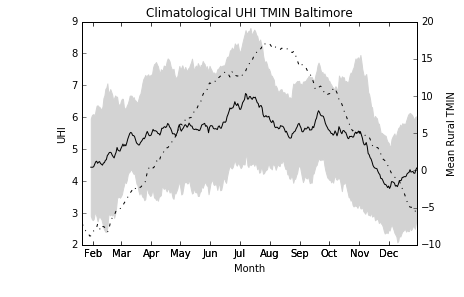

In [365]:
# first, plot yearly UHI cycle
results_filepath = 'plots/multistation_composites/'
UHI_seasonal_cycle(UHI, rural = rural_composite, results_filepath = results_filepath, city = city)
plt.annotate('Date range: \n %s - %s'%(rural_composite.index[0], rural_composite.index[-1]), xy=(.5, .05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

# second, compute JJA scatter of JJA rural temp vs. UHI
summertime_scatter(rural_tmin = rural_composite, urban_tmin = urban_composite, city = city, results_filepath=results_filepath)
plt.annotate('Date range: \n %s - %s'%(rural_composite.index[0], rural_composite.index[-1]), xy=(.5, .05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

# third, compute HW scatter of rural HW temp vs. UHI
heatwave_scatterplot(UHI, rural_tmin = rural_composite, results_filepath = 'plots/', city = city)
plt.annotate('Date range: \n %s - %s'%(rural_composite.index[0], rural_composite.index[-1]), xy=(.5, .05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')


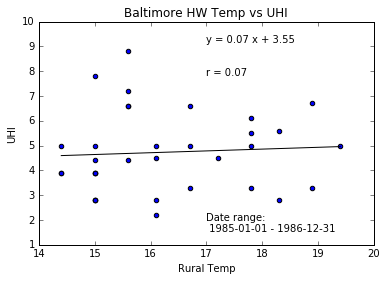

In [364]:
heatwave_scatterplot(UHI, rural_tmin = rural_composite, results_filepath = 'plots/', city = city)
plt.annotate('Date range: \n %s - %s'%(rural_composite.index[0], rural_composite.index[-1]), xy=(.5, .05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')


In [359]:
rural_composite.index

PeriodIndex(['1985-01-01', '1985-01-02', '1985-01-03', '1985-01-04',
             '1985-01-05', '1985-01-06', '1985-01-07', '1985-01-08',
             '1985-01-09', '1985-01-10',
             ...
             '1986-12-22', '1986-12-23', '1986-12-24', '1986-12-25',
             '1986-12-26', '1986-12-27', '1986-12-28', '1986-12-29',
             '1986-12-30', '1986-12-31'],
            dtype='int64', length=730, freq='D')

In [355]:
numhw = 150
finalhw = 50

hottestmin = rural_composite.iloc[(-rural_composite.values).argsort()[:numhw]] 
minheatwaves = hottestmin

# Make sure that events aren't duplicates 
# get the time difference between events (sorted in temporal order, obviously)
time_diff = (minheatwaves.sort_index().index.to_timestamp().values[1:] - minheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
# find where the events are not within 2 days of each other
minheatwaves = minheatwaves.sort_index().iloc[np.where(time_diff > np.timedelta64(2, 'D'))]
# Now the heatwaves are sorted in time order, but we want finalhw (50) of the most severe events. Save the hottest events
minheatwaves = minheatwaves.sort_values(ascending=False).iloc[0:finalhw]

In [358]:
rural_composite

1985-01-01     4.4
1985-01-02     1.7
1985-01-03    -2.2
1985-01-04    -2.8
1985-01-05    -3.3
1985-01-06    -6.1
1985-01-07    -2.8
1985-01-08    -6.7
1985-01-09   -11.7
1985-01-10   -13.3
1985-01-11    -9.4
1985-01-12   -11.7
1985-01-13    -9.4
1985-01-14    -7.2
1985-01-15   -10.0
1985-01-16   -12.8
1985-01-17    -6.7
1985-01-18    -3.9
1985-01-19    -7.8
1985-01-20   -22.2
1985-01-21   -24.4
1985-01-22   -15.0
1985-01-23   -10.6
1985-01-24    -5.6
1985-01-25    -7.2
1985-01-26   -11.1
1985-01-27   -13.3
1985-01-28   -10.0
1985-01-29   -10.0
1985-01-30   -12.2
              ... 
1986-12-02    -1.7
1986-12-03     5.6
1986-12-04    -0.6
1986-12-05    -5.0
1986-12-06    -7.8
1986-12-07    -2.8
1986-12-08     3.3
1986-12-09     3.3
1986-12-10     2.8
1986-12-11    -1.1
1986-12-12    -3.3
1986-12-13    -7.8
1986-12-14   -12.2
1986-12-15    -6.7
1986-12-16    -5.0
1986-12-17    -1.7
1986-12-18    -1.1
1986-12-19    -3.3
1986-12-20    -3.9
1986-12-21    -5.0
1986-12-22    -7.8
1986-12-23  

In [ ]:
# make slope map and/or histogram: edit functions to save out slopes and then aggregate into : 
# plot slope histograme
# data = slopes
# data = data[~np.isnan(data)]
# plt.figure(figsize=[8,12])
# plt.subplot(3,1,1)
# plt.hist(data, 20)
# plt.title('Slope of regression curve (UHI versus Temp for JJA)')
# #plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
# plt.ylabel('Count')
# plt.annotate('$ \mu $ = %2.2f'%data.mean(), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
# plt.annotate('$ \sigma $ = %2.2f'%data.std(), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
# plt.savefig(results_filepath + 'slopehistogram.png')

# # plot correlation histogram
# data = correlations
# data = data[~np.isnan(data)]
# plt.figure(figsize=[8,12])
# plt.subplot(3,1,2)
# plt.hist(data, 20)
# plt.title('Correlation of UHI with Temp for JJA')
# #plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
# plt.ylabel('Count')
# plt.annotate('$ \mu $ = %2.2f'%data.mean(), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
# plt.annotate('$ \sigma $ = %2.2f'%data.std(), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
# plt.savefig(results_filepath + '/correlationhistogram.png')

# # make a map of the slopes
# fig = plt.figure(figsize=[15,15])
# # Define colors 
# cmap = matplotlib.cm.coolwarm
# c = slopes
# bounds = np.linspace(-1,1,11)
# norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# marker_size = 75
# # Define the cartopy basemaps
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# ind = np.isnan(c)
# plotHandle = ax.scatter(paired_df['Urban Lon'], paired_df['Urban Lat'],#x,y,
#                         c = c, s = marker_size, transform=ccrs.Geodetic(),
#                  cmap = cmap,
#                  norm = norm)
# # mask insignificantly correlated cities with a white circle
# insig_inds = np.where(results_df['P-value']>0.05)

# ax.scatter(paired_df['Urban Lon'].iloc[insig_inds], paired_df['Urban Lat'].iloc[insig_inds], 
#         c = 'none', s = marker_size, transform=ccrs.Geodetic(), edgecolors='white',)

# cbar1 = plt.colorbar(plotHandle, label = 'Slope', orientation='horizontal')
# plt.title('Slope of UHI vs. Temp')
# plt.savefig(results_filepath + 'slopemap.png')